In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import numpy as np
import os
import sys

from influxdb_client import InfluxDBClient

sys.path.append('/app')
from torch_scaler import TorchStandardScaler



In [14]:

# Connect to InfluxDB
client = InfluxDBClient(url="http://ric_influxdb:8086", token="ric_admin_token", org="ric")



experiment_id = "exp_1740883750"
# Query data
query = '''
from(bucket: "network_metrics")
  |> range(start: -120h)
  |> filter(fn: (r) => r.experiment_id == "exp_1740883750")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> keep(columns: ["timestamp", "ue_id", "atten", "min_prb_ratio", "CQI", "RSRP", "DRB.UEThpDl", "DRB.RlcSduTransmittedVolumeDL"])
'''

result = client.query_api().query_data_frame(query=query)


# Convert columns to appropriate data types
result['ue_id'] = result['ue_id'].astype(int)
result['atten'] = result['atten'].astype(int) 
result['min_prb_ratio'] = result['min_prb_ratio'].astype(int)
result['CQI'] = result['CQI'].astype(int)
result['RSRP'] = result['RSRP'].astype(int)
result['DRB.UEThpDl'] = result['DRB.UEThpDl'].astype(float)
result['DRB.RlcSduTransmittedVolumeDL'] = result['DRB.RlcSduTransmittedVolumeDL'].astype(float)
result['timestamp'] = pd.to_datetime(result['timestamp'])

# Convert to pandas DataFrame
df = pd.DataFrame(result)
df

# Drop InfluxDB metadata columns
df.drop(columns=['result', 'table'], inplace=True)
df


,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
0,0,0,3,15,119906.0,120220.0,31,2025-03-02 02:49:51.186390
1,0,0,3,15,119917.0,120220.0,30,2025-03-02 02:49:52.218963
2,0,0,3,15,111191.0,110197.0,29,2025-03-02 02:49:53.237887
3,0,0,3,15,72303.0,72510.0,29,2025-03-02 02:49:54.268546
4,0,0,3,15,65883.0,64771.0,29,2025-03-02 02:49:55.287686
...,...,...,...,...,...,...,...,...
65,35,50,1,8,88233.0,88704.0,15,2025-03-02 02:50:23.017123
66,35,70,1,7,58403.0,57262.0,10,2025-03-02 02:50:24.041181
67,35,70,1,7,39913.0,39844.0,6,2025-03-02 02:50:25.057378
68,35,90,1,7,47437.0,48167.0,7,2025-03-02 02:50:26.082362


In [15]:
# in Mbps
df['DRB.UEThpDl'] = df['DRB.UEThpDl'] / 1000.0
df['DRB.RlcSduTransmittedVolumeDL'] = df['DRB.RlcSduTransmittedVolumeDL'] / 1000.0
df.describe()
df



,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
0,0,0,3,15,119.906,120.220,31,2025-03-02 02:49:51.186390
1,0,0,3,15,119.917,120.220,30,2025-03-02 02:49:52.218963
2,0,0,3,15,111.191,110.197,29,2025-03-02 02:49:53.237887
3,0,0,3,15,72.303,72.510,29,2025-03-02 02:49:54.268546
4,0,0,3,15,65.883,64.771,29,2025-03-02 02:49:55.287686
...,...,...,...,...,...,...,...,...
65,35,50,1,8,88.233,88.704,15,2025-03-02 02:50:23.017123
66,35,70,1,7,58.403,57.262,10,2025-03-02 02:50:24.041181
67,35,70,1,7,39.913,39.844,6,2025-03-02 02:50:25.057378
68,35,90,1,7,47.437,48.167,7,2025-03-02 02:50:26.082362


In [16]:

# grab ue1 data
ue1_df = df[df['ue_id'] == 1].copy()

# fix default min_prb_ratio at start (better to fix in experiment runner
# ue1_df['min_prb_ratio'] = ue1_df['min_prb_ratio'].replace(0, 50)
print(ue1_df.dtypes)
ue1_df

atten                                     int64
min_prb_ratio                             int64
ue_id                                     int64
CQI                                       int64
DRB.RlcSduTransmittedVolumeDL           float64
DRB.UEThpDl                             float64
RSRP                                      int64
timestamp                        datetime64[ns]
dtype: object


,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
35,10,50,1,15,121.716,121.910,31,2025-03-02 02:49:51.176746
36,10,70,1,15,121.705,122.130,30,2025-03-02 02:49:52.212894
37,10,70,1,15,121.705,122.020,29,2025-03-02 02:49:53.232742
38,10,90,1,15,138.241,140.192,29,2025-03-02 02:49:54.262621
39,10,90,1,15,170.687,171.312,29,2025-03-02 02:49:55.282307
40,15,50,1,15,219.481,219.983,29,2025-03-02 02:49:56.549371
41,15,50,1,15,215.896,212.199,29,2025-03-02 02:49:57.569825
42,15,70,1,14,114.854,114.914,28,2025-03-02 02:49:58.600767
43,15,70,1,14,107.628,107.349,28,2025-03-02 02:49:59.621108
44,15,90,1,14,146.372,149.403,28,2025-03-02 02:50:00.651714


In [17]:
ue1_df.describe()

,atten,min_prb_ratio,ue_id,CQI,DRB.RlcSduTransmittedVolumeDL,DRB.UEThpDl,RSRP,timestamp
count,35.000000,35.000000,35.0,35.000000,35.000000,35.000000,35.000000,35
mean,22.857143,70.571429,1.0,11.200000,112.203829,112.368771,22.428571,2025-03-02 02:50:09.186139392
min,10.000000,50.000000,1.0,7.000000,39.913000,39.844000,6.000000,2025-03-02 02:49:51.176746
25%,15.000000,50.000000,1.0,8.000000,71.007000,72.119000,16.000000,2025-03-02 02:50:00.136411136
50%,25.000000,70.000000,1.0,12.000000,114.854000,114.914000,26.000000,2025-03-02 02:50:09.309428992
75%,30.000000,90.000000,1.0,14.000000,137.083000,138.609000,28.000000,2025-03-02 02:50:18.205442816
max,35.000000,90.000000,1.0,15.000000,219.481000,219.983000,31.000000,2025-03-02 02:50:27.099116
std,8.513459,16.439346,0.0,3.007833,47.840750,47.996262,7.265089,NaN


In [18]:
# working on filtering out transient vals (not done)
# ue1_df['min_thp_per'] = df.groupby('min_prb_ratio')['DRB.UEThpDl'].transform('min')
# ue1_df[ue1_df['min_prb_ratio'] == 50]
#ue1_df[ue1_df['DRB.UEThpDl'] == ue1_df['min_thp_per']].to_string()

<Axes: xlabel='timestamp'>

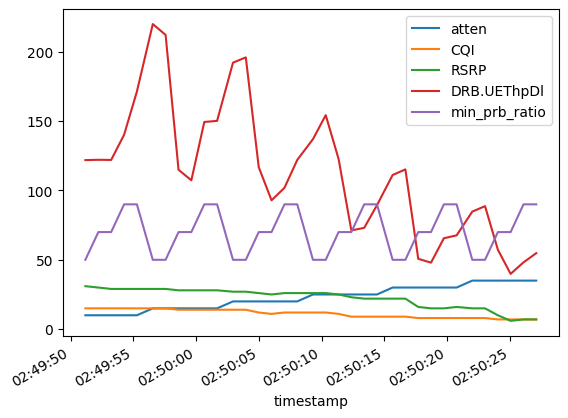

In [19]:
# get a general idea of what the relevant data points look like
ue1_df.plot(x='timestamp', y=['atten', 'CQI', 'RSRP', 'DRB.UEThpDl', 'min_prb_ratio'])

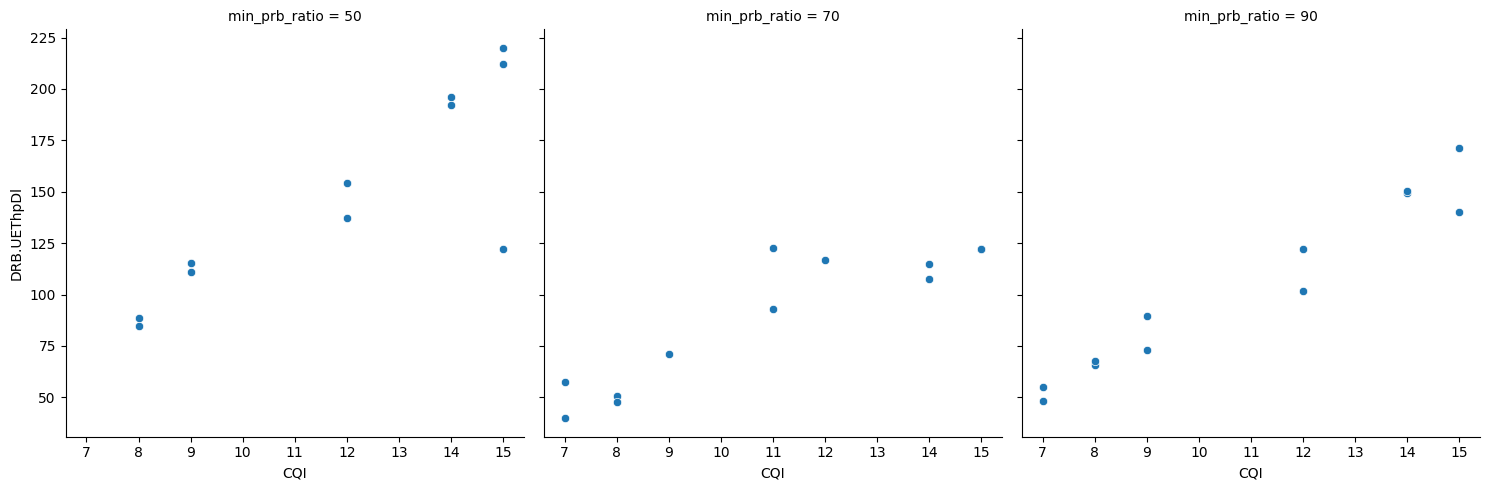

In [20]:
# Tput vs. CQI and min prb ratio
# note the transient values at the ratio switch points (95 -> 50 is the most egregious) 
sns.relplot(data=ue1_df, x='CQI', y='DRB.UEThpDl', col='min_prb_ratio')

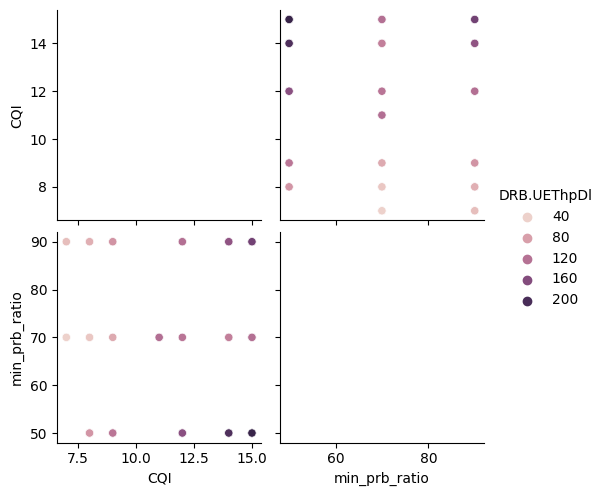

In [21]:
# another view
data = ue1_df[['CQI','DRB.UEThpDl', 'min_prb_ratio']]
sns.pairplot(data=data, hue='DRB.UEThpDl')
#sns.pairplot(data=data)

In [26]:
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
# print(f"device {device}")
device = 'cpu'

features = data[['CQI','DRB.UEThpDl']].values
targets = data[['min_prb_ratio']].values


# Convert features and targets to PyTorch tensors
X = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(targets, dtype=torch.float32)



In [34]:


class LinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 1)  # two input feature, one output feature
        self.register_buffer('x_mean', torch.zeros(2))
        self.register_buffer('x_std', torch.ones(2))
        self.register_buffer('y_mean', torch.zeros(1))
        self.register_buffer('y_std', torch.ones(1))

    def forward(self, x, denormalize=False):
        x_scaled = (x - self.x_mean) / self.x_std
        output = self.linear(x_scaled)
        if denormalize:
            output = output * self.y_std + self.y_mean
        return output


model = LinearRegressionModel()
model.x_mean = X.mean(dim=0, keepdim=True)
model.x_std = X.std(dim=0, keepdim=True)
model.y_mean = y.mean(dim=0, keepdim=True)
model.y_std = y.std(dim=0, keepdim=True)
model.to(device)
X.to(device)
y.to(device)
criterion = torch.nn.MSELoss() # Mean Squared Error
optimizer = torch.optim.SGD(model.parameters(), lr=.05)

# 4. Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    # Forward pass
    y_predicted = model(X)
    loss = criterion(y_predicted, (y - model.y_mean) / model.y_std)
    # Backward and optimize
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if (epoch) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/500], Loss: 1.1928
Epoch [101/500], Loss: 0.7369
Epoch [201/500], Loss: 0.7369
Epoch [301/500], Loss: 0.7369
Epoch [401/500], Loss: 0.7369


In [39]:
# Put model in eval mode before saving
model.eval()

# Save model to temporary file
import tempfile
import requests
import os

# Create temp file
temp_dir = tempfile.mkdtemp()
temp_model_path = os.path.join(temp_dir, "linear_regression.pt")

# Save model and scalers to a dictionary for later loading
# This includes both the model state and the feature/target scalers
model_id = "linear_regression_v1"
torch.save({
    'model_id': model_id,
    'model_state_dict': model, 
}, temp_model_path)

# Send to model server via REST API
with open(temp_model_path, 'rb') as f:
    files = {'model': f}
    response = requests.post(f'http://model-server:5000/models/{model_id}', files=files)
    
if response.status_code == 200:
    print("Model successfully uploaded to model server")
else:
    print(f"Error uploading model: {response.text}")
    
# Cleanup temp file
os.remove(temp_model_path)
os.rmdir(temp_dir)





Error uploading model: {
  "error": "Invalid model file: Failed to load model: Can't get attribute 'LinearRegressionModel' on <module '__main__' from '/app/app.py'>"
}



In [ ]:

# load the model from the model server
response = requests.get(f'http://model-server:5000/models/{model_id}')
model = response.json()['model']
model = torch.load(mo)

# generate some predictions across a range of input vals
# and unscale
model.eval()
with torch.no_grad():
    test_input = np.zeros((10 * 16, 2))
    for ii in range(10):
        test_input[ii * 16:ii * 16 + 16, 0] = ii + 6
        test_input[ii * 16:ii * 16 + 16, 1] = np.arange(50, 210, 10)
    test_input = torch.tensor(test_input, dtype=torch.float).to(device)
    # Transform the test input
    test_input_scaled = scaler_feat.transform(test_input.cpu().numpy())
    test_input_scaled = torch.tensor(test_input_scaled, dtype=torch.float, device=device)

    predicted_scaled = model(test_input_scaled)
    predicted = scaler_targ.inverse_transform(predicted_scaled.cpu().numpy())  # Inverse transform
    print(f'Predicted value for input {np.concatenate((test_input.cpu().numpy(), predicted), axis=1)}')


JSONDecodeError: Expecting value: line 1 column 1 (char 0)


Learned Hyperplane:
y = 0.56*x1 + -0.84*x2 + -0.00


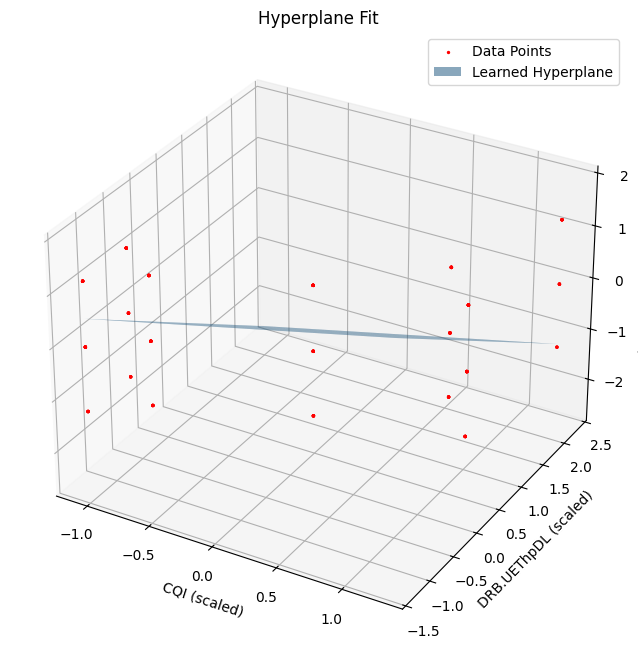

In [13]:
# look at the poor hyperplane fit
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Get the learned parameters
learned_weights = model.linear.weight.data.cpu().numpy()
learned_bias = model.linear.bias.data.cpu().numpy()

# Print the learned hyperplane equation
print("\nLearned Hyperplane:")
print(f"y = {learned_weights[0][0]:.2f}*x1 + {learned_weights[0][1]:.2f}*x2 + {learned_bias[0]:.2f}")

# Plot the data and the learned hyperplane
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the data points

ax.scatter(features_scaled[::5,0], features_scaled[::5,1], targets_scaled, c='r', marker='o', label='Data Points', s=2)

# Create a meshgrid for the hyperplane
x1_range = np.linspace(features_scaled[::5,0].min(), features_scaled[::5,0].max(), 20)
x2_range = np.linspace(features_scaled[::5,1].min(), features_scaled[::5,1].max(), 20)
X1, X2 = np.meshgrid(x1_range, x2_range)
Y_predicted_scaled = learned_weights[0][0] * X1 + learned_weights[0][1] * X2 + learned_bias[0]

# Plot the learned hyperplane
ax.plot_surface(X1, X2, Y_predicted_scaled, alpha=0.5, label='Learned Hyperplane')

# Set labels and title
ax.set_xlabel('CQI (scaled)')
ax.set_ylabel('DRB.UEThpDL (scaled)')
ax.set_zlabel('min_prb_ratio (scaled)')
ax.set_title('Hyperplane Fit')
ax.legend()

# Show the plot
plt.show()